In [5]:
# Constants
sigma = 10
img_path = '../resources/raw_imgs/chebu.jpg'

In [13]:
# Load in image
import numpy as np
from PIL import Image

def decompose_image(file_path):
    # Open the image file
    img = Image.open(file_path)
    
    # Convert the image to a NumPy array
    img_array = np.array(img)
    
    # Check if the image is RGB
    if len(img_array.shape) != 3 or img_array.shape[2] != 3:
        raise ValueError("The image must be in RGB format")
    
    # Decompose into R, G, B channels
    r_channel = img_array[:, :, 0]
    g_channel = img_array[:, :, 1]
    b_channel = img_array[:, :, 2]
    
    
    return r_channel, g_channel, b_channel

# Usage
r, g, b = decompose_image(img_path)

In [3]:
import numpy as np
def gaussian_kernel1d(sigma, radius):
    """
    Computes a 1-D Gaussian convolution kernel.
    """
    sigma2 = sigma * sigma
    x = np.arange(-radius, radius+1)
    phi_x = np.exp(-0.5 / sigma2 * x ** 2)
    phi_x = phi_x / phi_x.sum()

    return phi_x

In [16]:
kernel = gaussian_kernel1d(sigma, 30)
radius = int((len(kernel) - 1)/2)
one_side_sum = sum(kernel[0:radius])

np.float64(0.9999999999999998)

In [7]:
from scipy import sparse

# Creates a matrix with kernel shifted repeatedly. Multiplying the flattened vector by this matrix has
# the effect of blurring it horizontally.
# kernel must be symmetric and have an odd number width so it can be centered
def freivalds_matrix(kernel, height, width):
    numpixels = height * width
    matrix = sparse.dok_matrix((numpixels, numpixels), dtype=float)
    radius = int((len(kernel) - 1)/2)
    one_side_sum = sum(kernel[0:radius])
    
    # Use indexing [row, column] from now on.
    for pixel in range(0, numpixels):
        row, col = divmod(pixel, width)
        start_idx = pixel - radius
        row_start = row * width
        if row_start > start_idx:
            start_idx = row_start
        end_idx = pixel + radius
        # Make it the index of the last pixel rather than the start of next row.
        row_end = (row + 1) * width - 1
        if row_end < end_idx:
            end_idx = row_end
        
        matrix[pixel, pixel] = kernel[radius]
        
        remaining_left_mass = one_side_sum
        if start_idx == pixel:
            matrix[pixel, pixel] += remaining_left_mass
        else:
            col_index = pixel - 1
            filter_index = radius - 1
            while col_index > start_idx:
                matrix[pixel, col_index] = kernel[filter_index]
                remaining_left_mass -= kernel[filter_index]
                col_index -= 1
                filter_index -= 1
            matrix[pixel, col_index] += remaining_left_mass
                
                
        remaining_right_mass = one_side_sum
        if end_idx == pixel:
            matrix[pixel, pixel] += remaining_right_mass
        else:
            col_index = pixel + 1
            filter_index = radius + 1
            while col_index < end_idx:
                matrix[pixel, col_index] = kernel[filter_index]
                remaining_right_mass -= kernel[filter_index]
                col_index += 1
                filter_index += 1
            matrix[pixel, col_index] += remaining_right_mass
    return matrix

blur_matrix = freivalds_matrix(gaussian_kernel1d(sigma, 30), 400, 400)

In [40]:
# Run the 3 filters for each image plane
r_copy = np.copy(r)
g_copy = np.copy(g)
b_copy = np.copy(b)

image_channels = [r_copy, g_copy, b_copy]

for i in range(0, 3):
    # FFMPEG converts the channel to float32 for calculations
    channel = image_channels[i]
    channel = channel.astype(np.float32)
    horiz_blurred = blur_matrix @ channel.flatten()
    horiz_matrix = horiz_blurred.reshape(400, 400)
    verti_blurred = horiz_matrix.T
    final_image = blur_matrix @ verti_blurred.flatten()
    print("Channel max: ", np.max(channel))
    image_channels[i] = final_image.astype(np.uint8).reshape(400,400).T

Channel max:  255.0
Channel max:  255.0
Channel max:  250.0


In [16]:
# Define an image recombination function
# Reconstitute from R,G,B channels
def reconstitute_image(r,g,b):
    rgb_array = np.stack((r, g, b), axis=-1).astype(np.uint8)
    image = Image.fromarray(rgb_array, 'RGB')
    # Builtin in jupyter
    display(image)


# reconstitute_image(image_channels[0],image_channels[1],image_channels[2])

In [43]:
# Public Setup for Freivald's
freivalds_randomness = np.random.randint(0, 256, size=160000, dtype=np.uint8)
rTC = freivalds_randomness * blur_matrix


In [58]:
r_blurred = blur_matrix @ r.flatten()

# Verify
# assert(rTC.dot(r.flatten()) == freivalds_randomness.dot(r_blurred))

print(rTC.dot(r.flatten()))
print(freivalds_randomness.dot(r_blurred))

2044930616.0814357
2044930616.0814354


In [6]:
# Now do everything but with fixed-point arithmetic.

def gaussian_kernel1d_fixed_point(sigma, radius):
    fp_kernel = gaussian_kernel1d(sigma, radius)
    return (fp_kernel * (2**32)).astype(np.uint64)

def freivalds_matrix(kernel, height, width):
    numpixels = height * width
    matrix = sparse.dok_matrix((numpixels, numpixels), dtype=np.uint64)
    radius = int((len(kernel) - 1)/2)
    one_side_sum = sum(kernel[0:radius])
    
    # Use indexing [row, column] from now on.
    for pixel in range(0, numpixels):
        row, col = divmod(pixel, width)
        start_idx = pixel - radius
        row_start = row * width
        if row_start > start_idx:
            start_idx = row_start
        end_idx = pixel + radius
        # Make it the index of the last pixel rather than the start of next row.
        row_end = (row + 1) * width - 1
        if row_end < end_idx:
            end_idx = row_end
        
        matrix[pixel, pixel] = kernel[radius]
        
        remaining_left_mass = one_side_sum
        if start_idx == pixel:
            matrix[pixel, pixel] += remaining_left_mass
        else:
            col_index = pixel - 1
            filter_index = radius - 1
            while col_index > start_idx:
                matrix[pixel, col_index] = kernel[filter_index]
                remaining_left_mass -= kernel[filter_index]
                col_index -= 1
                filter_index -= 1
            matrix[pixel, col_index] += remaining_left_mass
                
                
        remaining_right_mass = one_side_sum
        if end_idx == pixel:
            matrix[pixel, pixel] += remaining_right_mass
        else:
            col_index = pixel + 1
            filter_index = radius + 1
            while col_index < end_idx:
                matrix[pixel, col_index] = kernel[filter_index]
                remaining_right_mass -= kernel[filter_index]
                col_index += 1
                filter_index += 1
            matrix[pixel, col_index] += remaining_right_mass
    return matrix

blur_matrix = freivalds_matrix(gaussian_kernel1d_fixed_point(sigma, 30), 400, 400)


NameError: name 'sparse' is not defined

In [64]:
# Run the 3 filters for each image plane
r_copy = np.copy(r)
g_copy = np.copy(g)
b_copy = np.copy(b)

image_channels = [r_copy, g_copy, b_copy]

for i in range(0, 3):
    # FFMPEG converts the channel to float32 for calculations
    channel = image_channels[i]
    channel = channel.astype(np.uint64)
    horiz_blurred = (blur_matrix @ channel.flatten()) / (2**32)
    horiz_matrix = horiz_blurred.reshape(400, 400)
    verti_blurred = horiz_matrix.T
    final_image = blur_matrix @ verti_blurred.flatten()
    print("Channel max: ", np.max(channel))
    image_channels[i] = (final_image/(2**32)).astype(np.uint8).reshape(400,400).T

Channel max:  255
Channel max:  255
Channel max:  250


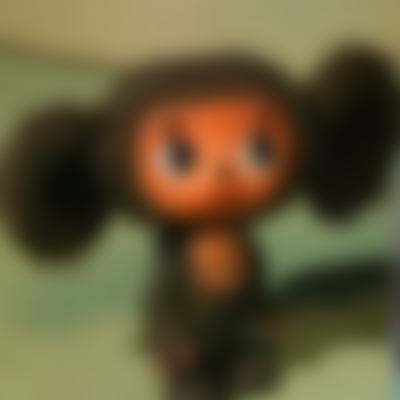

In [65]:
reconstitute_image(image_channels[0],image_channels[1],image_channels[2])

In [71]:
# Public Setup for Freivald's
freivalds_randomness = np.random.randint(0, 256, size=160000, dtype=np.uint64)
rTC = (freivalds_randomness * blur_matrix) 

r_blurred = (blur_matrix @ r.flatten()) 

# Verify
# assert(rTC.dot(r.flatten()) == freivalds_randomness.dot(r_blurred))

print(rTC.dot(r.flatten()))
print(freivalds_randomness.dot(r_blurred))

8775708264641405649
8775708264641405649


In [69]:
r_blurred

array([155.16913992, 155.34341045, 155.53262494, ..., 131.19196203,
       129.32780862, 127.50764094])

In [101]:
# New attempt: we use the optimized matrix packing where the image 
# is inputted as a matrix rather than a vector so much less randomness is required.

def gaussian_kernel1d_fixed_point(sigma, radius):
    fp_kernel = gaussian_kernel1d(sigma, radius)
    return (fp_kernel * (2**26)).astype(np.uint64)

# This is the same matrix for vert/horizontal blurring, you just transpose to get the 
# desired effect
def freivalds_matrix_optimized(kernel, height):
    # We will be building a matrix for left-multiplication, mostly because that is easier for me to reason about.
    matrix = np.zeros((height, height), dtype=np.uint64)
    radius = int((len(kernel) - 1)/2)
    one_side_sum = sum(kernel[0:radius])
    
    for row in range(0, height):
        filter_center = row
        # As before, set the start and end indices of where the filter gets "pasted" in so 
        start_idx = filter_center - radius
        if start_idx < 0:
            start_idx = 0
        end_idx = filter_center + radius
        if height - 1 < end_idx:
            end_idx = height - 1
        
        matrix[row, filter_center] = kernel[radius]
        
        remaining_left_mass = one_side_sum
        if start_idx == filter_center:
            matrix[row, filter_center] += remaining_left_mass
        else:
            col_index = filter_center - 1
            filter_index = radius - 1
            while col_index > start_idx:
                matrix[row, col_index] = kernel[filter_index]
                remaining_left_mass -= kernel[filter_index]
                col_index -= 1
                filter_index -= 1
            matrix[row, col_index] += remaining_left_mass
                
                
        remaining_right_mass = one_side_sum
        if end_idx == filter_center:
            matrix[row, filter_center] += remaining_right_mass
        else:
            col_index = filter_center + 1
            filter_index = radius + 1
            while col_index < end_idx:
                matrix[row, col_index] = kernel[filter_index]
                remaining_right_mass -= kernel[filter_index]
                col_index += 1
                filter_index += 1
            matrix[row, col_index] += remaining_right_mass
    return matrix

blur_matrix = freivalds_matrix_optimized(gaussian_kernel1d_fixed_point(sigma, 30), 400)

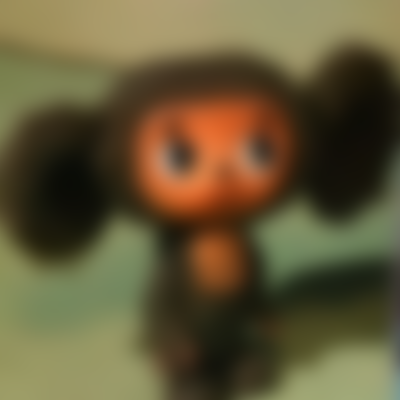

In [102]:
# Run the 3 filters for each image plane
r_copy = np.copy(r)
g_copy = np.copy(g)
b_copy = np.copy(b)

image_channels = [r_copy, g_copy, b_copy]

for i in range(0, 3):
    # FFMPEG converts the channel to float32 for calculations
    channel = image_channels[i]
    channel = channel.astype(np.uint64)
    verti_blurred = (blur_matrix @ channel / (2**26))
    horiz_blurred = verti_blurred.T
    # This is a bit sloppy: horizontal and vertical blur matrices will be of different sizes for non-square images.
    final_image = blur_matrix @ horiz_blurred
    image_channels[i] = (final_image/(2**26)).astype(np.uint8).T
                     
reconstitute_image(image_channels[0],image_channels[1],image_channels[2])

In [103]:
# Public Setup for Freivald's mod 2^64 (not realy secure)
freivalds_randomness_left = np.random.randint(0, 2**64 - 1, size=400, dtype=np.uint64)
freivalds_randomness_right = np.random.randint(0, 2**64 - 1, size=400, dtype=np.uint64)
rLeftTB = (freivalds_randomness_left @ blur_matrix) 
rRightTB = (blur_matrix @ freivalds_randomness_right)

r_blurred = (blur_matrix @ r) @ blur_matrix

# # Verify
# assert(((rLeftTB @ r) @ rRightTB) == (freivalds_randomness_left @ r_blurred) @ freivalds_randomness_right)
print(((rLeftTB @ r) @ rRightTB))
print((freivalds_randomness_left @ r_blurred) @ freivalds_randomness_right)
# print(rTC.dot(r.flatten()))
# print(freivalds_randomness.dot(r_blurred))
# print(rLeftTB)

3542301786889497556
3542301786889497556


In [104]:
goldilocks_prime = 2**64 - 2**32 + 1
freivalds_randomness_left = np.random.randint(0, goldilocks_prime - 1, size=400, dtype=np.uint64)
freivalds_randomness_right = np.random.randint(0, goldilocks_prime - 1, size=400, dtype=np.uint64)

# Public Setup
rLeftTB = np.zeros(400, dtype=np.uint64)
for i in range(0, 400):
    for j in range(0, 400):
        old = int(rLeftTB[j])
        coefficient = int(freivalds_randomness_left[i])
        matrix_val = int(blur_matrix[i,j])
        rLeftTB[j] = (old + coefficient * matrix_val) % goldilocks_prime
        
bRright = np.zeros(400, dtype=np.uint64)
for i in range(0, 400):
    for j in range(0, 400):
        old = int(bRright[i])
        coefficient = int(freivalds_randomness_right[j])
        matrix_val = int(blur_matrix[i,j])
        bRright[i] = (old + coefficient * matrix_val) % goldilocks_prime

r_blurred = (blur_matrix @ r) @ blur_matrix

# Compute inner product for r
rLeftTBR_product = np.zeros(400, dtype=np.uint64)
for i in range(0, 400):
    for j in range(0, 400):
        old = int(rLeftTBR_product[j])
        coefficient = int(rLeftTB[i])
        matrix_val = int(r[i,j])
        rLeftTBR_product[j] = (old + coefficient * matrix_val) % goldilocks_prime

inner_product_left = 0
for i in range(0, 400):
    old = int(inner_product_left)
    coefficient = int(rLeftTBR_product[i])
    randomness = int(bRright[i])
    inner_product_left = (old + coefficient * randomness) % goldilocks_prime
        
# Compute inner product for r_blurred:
r_left_r_blur_product = np.zeros(400, dtype=np.uint64)
for i in range(0, 400):
    for j in range(0, 400):
        old = int(r_left_r_blur_product[j])
        coefficient = int(freivalds_randomness_left[i])
        matrix_val = int(r_blurred[i,j])
        r_left_r_blur_product[j] = (old + coefficient * matrix_val) % goldilocks_prime
        
inner_product_right = 0
for i in range(0, 400):
    old = int(inner_product_right)
    coefficient = int(r_left_r_blur_product[i])
    randomness = int(freivalds_randomness_right[i])
    inner_product_right = (old + coefficient * randomness) % goldilocks_prime
    
print(inner_product_left, inner_product_right)

16050996141881190124 16050996141881190124


In [64]:
rLeftTB = np.zeros(400, dtype=np.uint64)
for i in range(0, 400):
    for j in range(0, 400):
        old = int(rLeftTB[j])
        coefficient = int(freivalds_randomness_left[i])
        matrix_val = int(blur_matrix[i,j])
        rLeftTB[j] = (old + coefficient * matrix_val) % goldilocks_prime
        
bRright = np.zeros(400, dtype=np.uint64)
for i in range(0, 400):
    for j in range(0, 400):
        old = int(bRright[i])
        coefficient = int(freivalds_randomness_right[j])
        matrix_val = int(blur_matrix[i,j])
        bRright[i] = (old + coefficient * matrix_val) % goldilocks_prime

r1TB = ((freivalds_randomness_left.astype(int) @ blur_matrix.astype(int)) % goldilocks_prime).astype(np.uint64)

OverflowError: Python int too large to convert to C long

In [90]:
product = ((r_left_r_blur_product.astype(np.float64) @ freivalds_randomness_right.astype(np.float64))) % goldilocks_prime
product = product.astype(np.uint64)
print(inner_product_right)
print(product)

6173793392205658426
9110574783933710336


In [83]:
goldilocks_prime > 18446656794428677460

True

In [94]:
z = 2**128
z *= 2
print(z)

680564733841876926926749214863536422912
